<a href="https://colab.research.google.com/github/jennkimerson/OCR_ArchivalDataOrganization_HGARC/blob/master/Mk4c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mk. 4
Reads in text by binding individual characters with boxes in attempts to preserve white spaces.

Work in progress, last updated 5/23/2019

## I. Data Selection
Prompts the user to select pages they want to read in

In [0]:
!pip install PyPDF2

     |████████████████████████████████| 81kB 5.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [0]:
import PyPDF2

# takes in a file from the user and imports the image file
from google.colab import files

uploaded = files.upload()

Saving sample.pdf to sample.pdf


## II. File Conversion
Read in PDF to images

In [0]:
!sudo apt install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 154 kB of archives.
After this operation, 608 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.8 [154 kB]
Fetched 154 kB in 1s (156 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: 

In [0]:
!pip install pdf2image

  Stored in directory: /root/.cache/pip/wheels/17/66/fa/943596ab784ee79f804b7ecb79dbe97aee8f7665dbbf9f9d94
Successfully built pdf2image


In [0]:
from pdf2image import convert_from_path

In [0]:
pages = convert_from_path('sample.pdf', 200) #convert_from_path(file_name, dpi) returns an array of images, one for each page
len(pages)

44

In [0]:
for i in range(len(pages)):
    pages[i].save('input' + str(i) + '.jpg', 'JPEG')

## III. Enhance Image
Reduce the background noise in images for accurate scanning

Credit to: 
https://gist.github.com/githubharald/24052afa05b6811b7f7a821fea1ef6e8#file-preprocesstextimage-py

In [0]:
import numpy as np
import cv2

In [0]:
# read
img = cv2.imread('input5.jpg', cv2.IMREAD_GRAYSCALE)

In [0]:
# increase contrast - would like to scale on a non-linear level but have yet to understand how to do such
pxmin = np.min(img)
pxmax = np.max(img)
imgContrast = (img - pxmin) / (pxmax - pxmin) * 255
print(pxmin, pxmax)

0 255


In [0]:
# increase line width
kernel = np.ones((3, 3), np.uint8)
imgMorph = cv2.erode(imgContrast, kernel, iterations = 1)

In [0]:
# write
cv2.imwrite('sample.jpg', imgMorph)

True

In [0]:
from PIL import Image

img = Image.open("sample.jpg")
rgb_img = img.convert('RGB')
rgb_img.save('sample.jpeg')

##IV. Binding boxes with Enclosed Characters
Finds all text characters in the image and returns binidng boxes with enclosed characters

In [0]:
!pip install pytesseract
!sudo apt install tesseract-ocr
#!git clone https://github.com/jennkimerson/OCR_ArchivalDataOrganization_HGARC.git

     |████████████████████████████████| 174kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/90/56/ab7b652592da86821293f7cadc1c554aa376a0d57ce414d0a0
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00f

In [0]:
import pytesseract
from pytesseract import Output

In [0]:
#open segmented image to be processed

try:
    from PIL import Image
except ImportError:
    import Image
    
img = Image.open('sample.jpeg')

In [0]:
#draw boxes around each of the found characters

import cv2
import numpy as np

nparray = np.array(img)

h, w, _ = nparray.shape

#char with bounding boxes
boxes = pytesseract.image_to_boxes(img)

# draw the bounding boxes on the image
for b in boxes.splitlines():
    b = b.split(' ')
    draw = cv2.rectangle(nparray, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2) #currently outputs wrong color scheme

#fixes color error
RGB_img = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

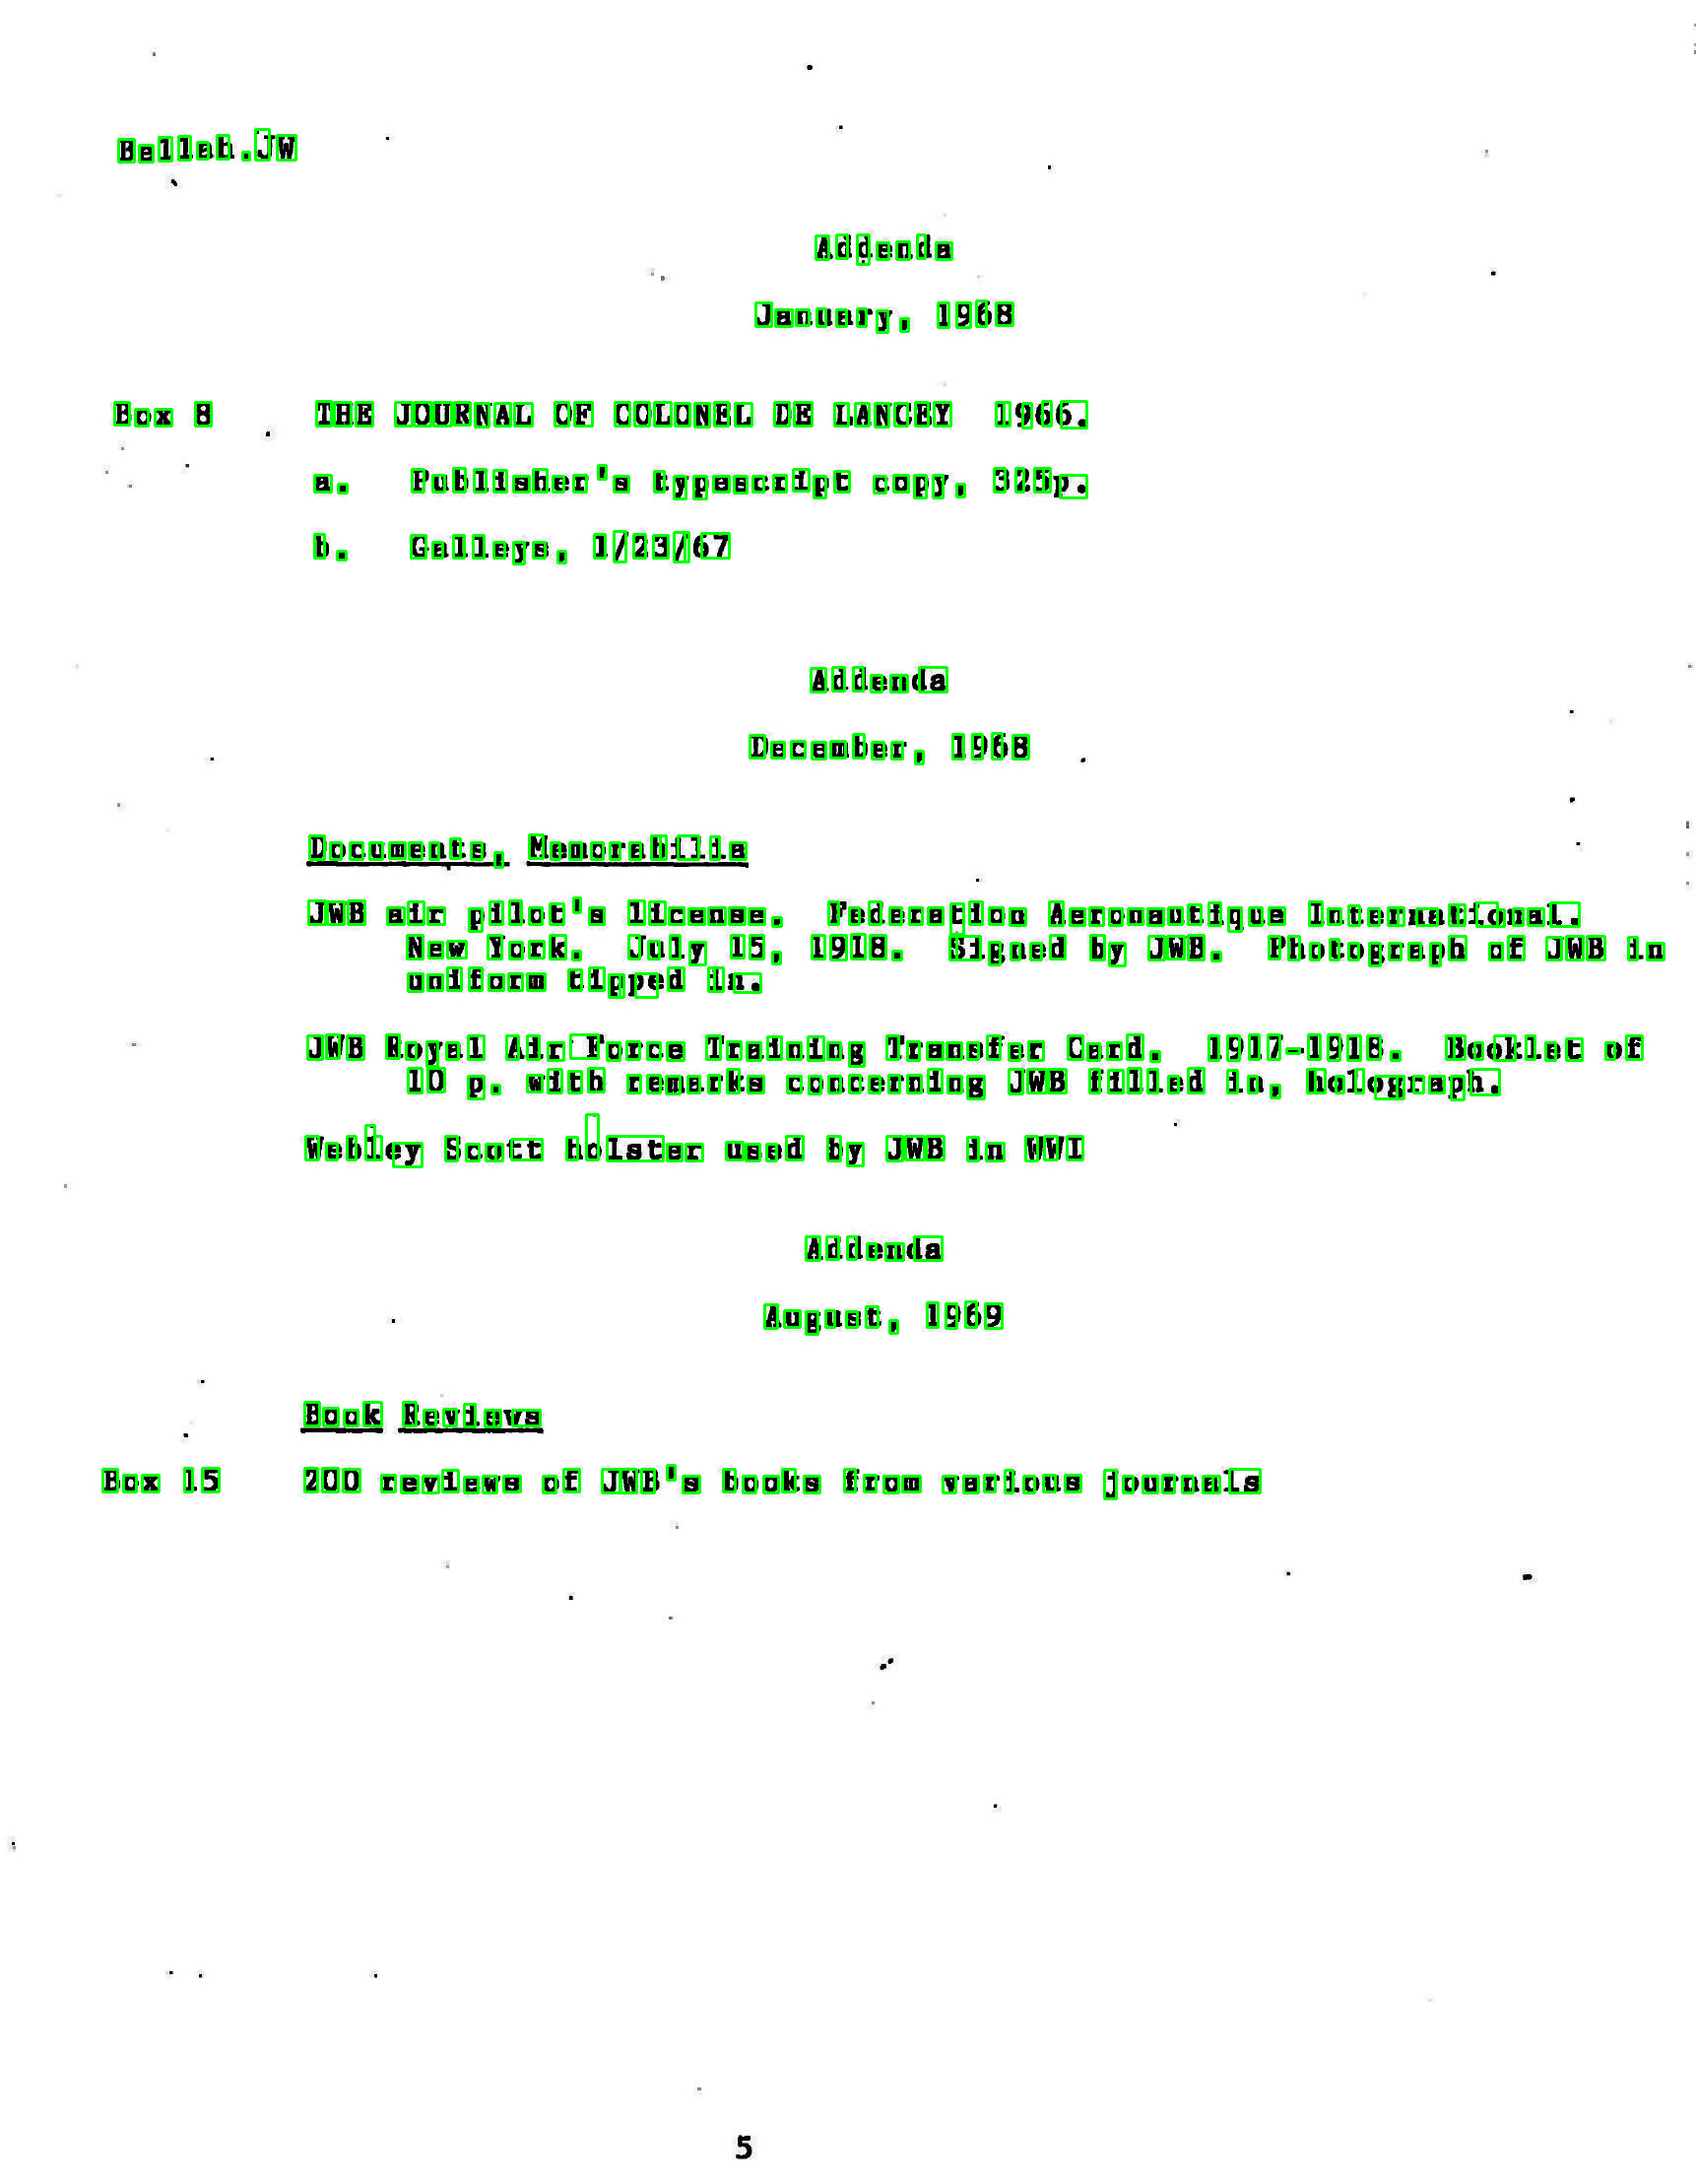

In [0]:
#show result
from google.colab.patches import cv2_imshow
#%matplotlib
cv2_imshow(RGB_img)

##V. Find Minimum X Coordinate Value
Get coordinates of all boxes in order to find the minimum x coordniate value. This is where we will start counting white spaces.

In [0]:
#size of the segmented image in width and hieght

width, height = img.size
print (width, height)

1722 2217


In [0]:
#find all characters and their coordinates in the image

from pytesseract import pytesseract as pt

coord = pt.image_to_boxes(img)

# (debug line) print(coord)

In [0]:
#break string

coordListPrep = sentences = coord.splitlines()
#coordList = coord[0:len(coord)-1].split("\n")
# (debug line) print(coordListPrep)

coordList = []
for i in range(0, len(coordListPrep)):
  new = coordListPrep[i].split(" ")
  coordList.append(new)
  
# (debug line) print(coordList)

x = 1
y = 2
w = 3
h = 4

In [0]:
#consolidate x coordinates into an array to find min x coordinate

xcoords = []

for i in range(len(coordList)):
  current = int(coordList[i][x])
  #round current value to nearest multiple of 5 to reduce variability
  #rounded = 10 * round(current/10)
  xcoords.append(current)

# (debug line) print(xcoords)


#find min x coordinate to find the first occuring letter
x_min = min(xcoords)

print ("min x coordinate vlaue : ", x_min)


x_max = max(xcoords)
print ("max x coordinate vlaue : ", x_max)

min x coordinate vlaue :  104
max x coordinate vlaue :  1672


In [0]:
# (debug line) print(xcoords)

xcoordscut = []
xcoordscut[:] = [x - x_min  for x in xcoords]

# (debug line) print(xcoordscut)

trimList = coordList.copy()
for box in trimList:
  box[x] = int(box[x]) - x_min
  box[y] = int(box[y])
  box[w] = int(box[w]) - x_min
  box[h] = int(box[h])

In [0]:
#find s(span) of the documnet that the text covers
#X max - X min = Span

span = x_max - x_min
print ("Span of text in the document: ", span)

Span of text in the document:  1568


In [0]:
#define domain to be some fraction (do it later) of s
#domain is the region of the page that is compared with Mk.2
#domain = (p / q) * s

#uncertain about how this boundary should go about, so we'll code it in later

In [0]:
boxalphnum = []
for box in trimList:
   if box[0].isalnum():
      boxalphnum.append(box)

# (debug line) print(boxalphnum)

In [0]:
# (debug line) trimList[:]

In [0]:
f_x = []
f_y = []
for box in boxalphnum:
  f_x.append(box[w] - box[x])
  f_y.append(box[h] - box[y])
  
# (debug line) print(f_x)
# (debug line) print(f_y)

In [0]:
#define average font size and standard deviation

f__x = np.mean(f_x)
f__y = np.mean(f_y)
sigma_x = np.std(f_x)
sigma_y = np.std(f_y)

print("average font size, x direction: ", f__x)
print("average font size, y direction: ", f__y)
print("standard deviation, x direction: ", sigma_x)
print("standard deviation, y direction: ", sigma_y)

# dev_x = round(k * sigma_x)
dev_y = int(3 * round(sigma_y))

average font size, x direction:  13.535087719298245
average font size, y direction:  21.04605263157895
standard deviation, x direction:  4.1920556121625125
standard deviation, y direction:  3.753370676582105


In [0]:
#define tolerance

k = 0.2 #this should be adjusted
tau = f__x + sigma_x * k

In [0]:
#identify y-clusters
#this part could be coded better

lines_y = []
for box in trimList:
  sentinel = True
  y_val = box[y]
  if box[0] == "\"" or box[0] == "\'":
    y_val -= int(round(f__y / 2))
  wingspan = range(y_val - dev_y, y_val + dev_y + 1)
  for wings in wingspan:
    if wings in lines_y:
      sentinel = False
  if sentinel:
    lines_y.append(box[y])

# (debug line) print(lines_y)

print("number of lines: ", len(lines_y))

number of lines:  19


In [0]:
#separate boxes into given clusters
#this part could also be coded better

boxlines = [[] for _ in range(len(lines_y))]
for box in trimList:
  y_val = box[y]
  if box[0] == "\"" or box[0] == "\'":
    y_val -= int(round(f__y / 2))
  wingspan = range(y_val - dev_y, y_val + dev_y + 1)
  for wings in wingspan:
    if wings in lines_y:
      dex = lines_y.index(wings)
      #print(dex)
      break     
  boxlines[dex].append(box)

# (debug line) boxlines

In [0]:
#sort the y-clusters
def ykey(line):
  return line[0][y]

boxlines.sort(key = ykey, reverse = True)
boxlines

[[['B', 16, 2053, 32, 2076, '0'],
  ['e', 37, 2053, 51, 2070, '0'],
  ['l', 57, 2054, 70, 2078, '0'],
  ['l', 77, 2055, 89, 2079, '0'],
  ['a', 96, 2056, 107, 2073, '0'],
  ['h', 116, 2056, 128, 2080, '0'],
  ['.', 142, 2055, 149, 2063, '0'],
  ['J', 155, 2055, 169, 2086, '0'],
  ['W', 177, 2055, 196, 2080, '0']],
 [['A', 724, 1954, 737, 1978, '0'],
  ['d', 745, 1955, 756, 1979, '0'],
  ['d', 766, 1949, 778, 1979, '0'],
  ['e', 786, 1954, 798, 1971, '0'],
  ['n', 806, 1954, 819, 1972, '0'],
  ['d', 827, 1955, 835, 1979, '0'],
  ['a', 846, 1954, 862, 1971, '0']],
 [['J', 663, 1886, 679, 1910, '0'],
  ['a', 683, 1886, 700, 1903, '0'],
  ['n', 704, 1887, 717, 1903, '0'],
  ['u', 725, 1886, 734, 1904, '0'],
  ['a', 745, 1886, 755, 1903, '0'],
  ['r', 766, 1886, 775, 1904, '0'],
  ['y', 786, 1880, 797, 1902, '0'],
  [',', 810, 1881, 818, 1894, '0'],
  ['1', 848, 1885, 859, 1910, '0'],
  ['9', 867, 1885, 881, 1910, '0'],
  ['6', 887, 1886, 897, 1912, '0'],
  ['8', 907, 1887, 924, 1910, '0']]

In [0]:
#assemble raw strings
#and also edit rawline to add intraword and interwrod spaces
rawlines = []
for line in boxlines:
  rawline = "" + int((line[0][x])/ tau) * " "
  
  for i in range(len(line)):
    box = line[i]
    rawline += box[0]
    
    if (i+1) == len(line):
      break
      
    nextbox = line[i + 1]
    
    
    #adjust sigma_x coefficient as needed
    gap = nextbox[x] - box[w]
    
    if gap >= tau:
      space = int(gap / tau)
      rawline += space * " "
      
  rawlines.append(rawline + "\n")
  
rawlines

['Bellah.JW\n',
 '                                        Addenda\n',
 '                                     January, 1968\n',
 'Box 8      THE JOURNAL OF COLONEL DE LANCEY  1966,\n',
 "            a.   Publisher's typescript copy, 325p.\n",
 '            b.   Galleys, 1/23/67\n',
 '                                        Addenda\n',
 '                                     December, 1968\n',
 '           Documents, Memorabilia\n',
 "           JWB air pilot's license.  Federation Aeronautique International.\n",
 '                 New York.  July 15, 1918.  Signed by JWB.  Photograph of JWB in\n',
 '                 uniform tipped in.\n',
 '           JWB Royal AirForce Training Transfer Card.  1917-1918.  Booklet of\n',
 '                 10 p. with remarks concerning JWB filled in, holograph.\n',
 '           Webley Scott frags used by JWB in WWI\n',
 '                                        Addenda\n',
 '                                     August, 1969\n',
 '           Book Reviews\n

In [0]:
text = " ".join(rawlines)

print(text)

Bellah.JW
                                         Addenda
                                      January, 1968
 Box 8      THE JOURNAL OF COLONEL DE LANCEY  1966,
             a.   Publisher's typescript copy, 325p.
             b.   Galleys, 1/23/67
                                         Addenda
                                      December, 1968
            Documents, Memorabilia
            JWB air pilot's license.  Federation Aeronautique International.
                  New York.  July 15, 1918.  Signed by JWB.  Photograph of JWB in
                  uniform tipped in.
            JWB Royal AirForce Training Transfer Card.  1917-1918.  Booklet of
                  10 p. with remarks concerning JWB filled in, holograph.
            Webley Scott frags used by JWB in WWI
                                         Addenda
                                      August, 1969
            Book Reviews
 Box 15    200 reviews of JWB's books from various journals



In [0]:
# converts string to text file
from google.colab import files

with open('output.txt', 'w') as f:
  f.write(text)

files.download('output.txt')

## VI. Quality Check
Match the transposed vertical text file with horizontally scanned result to quality check

In [0]:
# converts image file to string
# does not preserve white space
text = pytesseract.image_to_string(Image.open('image.jpg'), config='-psm 6')

#print (result)
print (({0}".format(text))

## VII. Structure Selection & Data Categorization
Prompts the user for structure (formatting and organization of data)

## VIII. Reassemble Data
Create a CSV or Excel file with the processed data

In [0]:
! pip install XlsxWriter
! pip install pandas
import pandas as pd

    100% |████████████████████████████████| 143kB 6.6MB/s 


In [0]:
df= pd.DataFrame(split)
#df = df.transpose()

print(df)

In [0]:
df.to_excel("output.xlsx")